# Guided Project: Predicting House Sale Prices

In this guided project, we will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. We will train a model to predict prices based on the dataset we will use.

More on why the data was collected can be read [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). Information about the different columns in the data can be found [here](https://s3.amazonaws.com/dq-content/307/data_description.txt).

Let's start by setting up a pipeline of functions that will let us quickly iterate on different models.

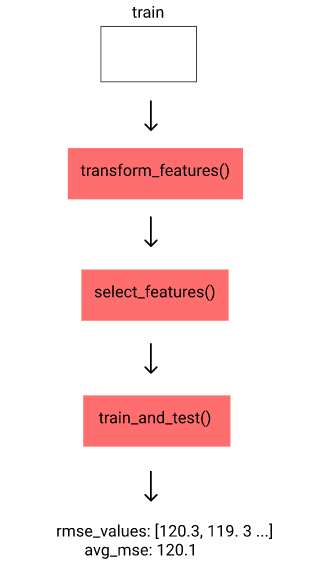

In [50]:
import pandas as pd
pd.options.display.max_columns = 999
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import seaborn as sns

%matplotlib inline

In [51]:
ames = pd.read_csv('AmesHousing.tsv', delimiter='\t')
ames.shape

(2930, 82)

In [52]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
    train = data[:1460]
    test = data[1460:]
    
    numeric_train = train.select_dtypes(include=['float','integer'])
    numeric_test = test.select_dtypes(include=['float', 'integer'])
    numeric_train = numeric_train.drop('SalePrice', axis=1)
    features = numeric_train.columns
    
    lr = LinearRegression()
    lr.fit(train[features], train['SalePrice'])
    predictions = lr.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

In [53]:
data = transform_features(ames)
selected = select_features(data)
rmse = train_and_test(selected)

rmse

57088.25161263909

## Feature Engineering

Let's now start removing features with many missing values, diving deeper into potential categorical features, and transforming text and numerical columns. We will update `transform_features()` so that any column from the data frame with more than 25% missing values is dropped. We also need to remove any columns that leak information about the sale (e.g. like the year the sale happened). In general, the goal of this function is to:

- remove features that we do not want to use in the model, just based on the number of missing values or data leakage
- transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)
- create new features by combining other features

Next, we need to get more familiar with the remaining columns by reading the [data documentation](https://s3.amazonaws.com/dq-content/307/data_description.txt) for each column, determining what transformations are necessary (if any), and more.

In [54]:
#Which columns contain less than 5% missing values?

sum_missing = ames.isnull().sum()
over_5 = sum_missing[sum_missing > 146].index
ames = ames.drop(over_5, axis=1)

#For numerical columns, let's fill in the missing values using 
#the most popular value for that column

numeric_missing = ames.select_dtypes(include=['float', 'integer']).isnull().sum()
to_fix = numeric_missing[numeric_missing > 0].sort_values()
to_fix

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [55]:
for col in to_fix.index:
    value = ames[col].mode()[0]
    ames[col] = ames[col].fillna(value)

In [56]:
#Let's remove the Text columns with over 1 missing value

object_missing = ames.select_dtypes(include='object').isnull().sum()
over_1 = object_missing[object_missing > 0].index
ames = ames.drop(over_1, axis=1)

In [57]:
ames.isnull().sum().sort_values(ascending=False)

SalePrice          0
Sale Condition     0
BsmtFin SF 2       0
BsmtFin SF 1       0
Foundation         0
                  ..
Low Qual Fin SF    0
2nd Flr SF         0
1st Flr SF         0
Central Air        0
Order              0
Length: 64, dtype: int64

What new features can we create, that better capture the information in some of the features?

- create a column named `years_until_remod` which will store the difference between the `Year Remod/Add` and `Year Built` columns.
- create a column named `years_when_sold` which will store the difference between the `Yr Sold` and `Year Built` columns.
- create a column named `years_since_remod` which will store the difference between the `Year Remod/Add` and `Yr Sold` columns.

In [58]:
ames['year_until_remod'] = ames['Year Remod/Add'] - ames['Year Built']
ames['years_when_sold'] = ames['Yr Sold'] - ames['Year Built']
ames['years_since_remod'] =  ames['Yr Sold'] - ames['Year Remod/Add']

Finally, let's drop the columns which are not useful for machine learning. Such columns are:

- `Order` - which repeats the index
- `PID` - which includes the property identification numbers

We also need to drop columns which leak information about the final sale:

- `Mo Sold`
- `Sale Type`
- `Sale Condition`
- `Yr Sold`

In [59]:
ames = ames.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Yr Sold'], axis=1)

Let's update the `transform_features()` function.

In [60]:
def transform_features(df):
    """
    Takes in a DataFrame, cleans up the missing values, adds new columns and returns the cleaned up DataFrame
    """
    sum_missing = df.isnull().sum()
    over_5 = sum_missing[sum_missing > len(df)/20].index
    df = df.drop(over_5, axis=1)
    
    numeric_missing = df.select_dtypes(include=['float', 'integer']).isnull().sum()
    to_fix = numeric_missing[numeric_missing > 0].sort_values()
    for col in to_fix.index:
        value = df[col].mode()[0]
        df[col] = df[col].fillna(value)
        
    object_missing = df.select_dtypes(include='object').isnull().sum()
    over_1 = object_missing[object_missing > 0].index
    df = df.drop(over_1, axis=1)
    
    df['year_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    df['years_when_sold'] = df['Yr Sold'] - df['Year Built']
    df['years_since_remod'] =  df['Yr Sold'] - df['Year Remod/Add']
    
    df = df.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Yr Sold'], axis=1)
    
    return df

transformed_df = transform_features(pd.read_csv('AmesHousing.tsv', delimiter='\t'))
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)

rmse

57088.25161263909

## Feature Selection

Now that we have cleaned and transformed a lot of the features in the data set, it's time to move on to feature selection for numerical features.

We will first generate a correlation heatmap matrix of the numerical features in the training data set.

- Which features correlate strongly with our target column, `SalePrice`?
- Calculate the correlation coefficients for the columns that seem to correlate well with `SalePrice`. Because we have a pipeline in place, it's easy to try different features and see which features result in a better cross validation score.

In [61]:
numeric = transformed_df.select_dtypes(include=['float', 'integer'])
numeric.head()

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,year_until_remod,years_when_sold,years_since_remod
0,20,31770,6,5,1960,1960,112.0,639.0,0.0,441.0,1080.0,1656,0,0,1656,1.0,0.0,1,0,3,1,7,2,2.0,528.0,210,62,0,0,0,0,0,215000,0,50,50
1,20,11622,5,6,1961,1961,0.0,468.0,144.0,270.0,882.0,896,0,0,896,0.0,0.0,1,0,2,1,5,0,1.0,730.0,140,0,0,0,120,0,0,105000,0,49,49
2,20,14267,6,6,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,0,0,1329,0.0,0.0,1,1,3,1,6,0,1.0,312.0,393,36,0,0,0,0,12500,172000,0,52,52
3,20,11160,7,5,1968,1968,0.0,1065.0,0.0,1045.0,2110.0,2110,0,0,2110,1.0,0.0,2,1,3,1,8,2,2.0,522.0,0,0,0,0,0,0,0,244000,0,42,42
4,60,13830,5,5,1997,1998,0.0,791.0,0.0,137.0,928.0,928,701,0,1629,0.0,0.0,2,1,3,1,6,1,2.0,482.0,212,34,0,0,0,0,0,189900,1,13,12


In [62]:
corr = numeric.corr()['SalePrice'].abs().sort_values(ascending=False)
corr

SalePrice            1.000000
Overall Qual         0.799262
Gr Liv Area          0.706780
Garage Cars          0.647812
Garage Area          0.640138
Total Bsmt SF        0.632529
1st Flr SF           0.621676
years_when_sold      0.558907
Year Built           0.558426
Full Bath            0.545604
years_since_remod    0.534940
Year Remod/Add       0.532974
Mas Vnr Area         0.502196
TotRms AbvGrd        0.495474
Fireplaces           0.474558
BsmtFin SF 1         0.433147
Wood Deck SF         0.327143
Open Porch SF        0.312951
Half Bath            0.285056
Bsmt Full Bath       0.275823
2nd Flr SF           0.269373
Lot Area             0.266549
year_until_remod     0.240168
Bsmt Unf SF          0.183308
Bedroom AbvGr        0.143913
Enclosed Porch       0.128787
Kitchen AbvGr        0.119814
Screen Porch         0.112151
Overall Cond         0.101697
MS SubClass          0.085092
Pool Area            0.068403
Low Qual Fin SF      0.037660
Bsmt Half Bath       0.035817
3Ssn Porch

In [63]:
#Let's drop the columns with correlation under 0.4:

to_drop = corr[corr < 0.4].index
transformed_df = transformed_df.drop(to_drop, axis=1)

In [64]:
transformed_df.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,BsmtFin SF 1,Total Bsmt SF,Heating,Heating QC,Central Air,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Garage Cars,Garage Area,Paved Drive,SalePrice,years_when_sold,years_since_remod
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,1960,1960,Hip,CompShg,BrkFace,Plywood,112.0,TA,TA,CBlock,639.0,1080.0,GasA,Fa,Y,1656,1656,1,TA,7,Typ,2,2.0,528.0,P,215000,50,50
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,1961,1961,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,CBlock,468.0,882.0,GasA,TA,Y,896,896,1,TA,5,Typ,0,1.0,730.0,Y,105000,49,49
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,108.0,TA,TA,CBlock,923.0,1329.0,GasA,TA,Y,1329,1329,1,Gd,6,Typ,0,1.0,312.0,Y,172000,52,52
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,1968,1968,Hip,CompShg,BrkFace,BrkFace,0.0,Gd,TA,CBlock,1065.0,2110.0,GasA,Ex,Y,2110,2110,2,Ex,8,Typ,2,2.0,522.0,Y,244000,42,42
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,0.0,TA,TA,PConc,791.0,928.0,GasA,Gd,Y,928,1629,2,TA,6,Typ,1,2.0,482.0,Y,189900,13,12


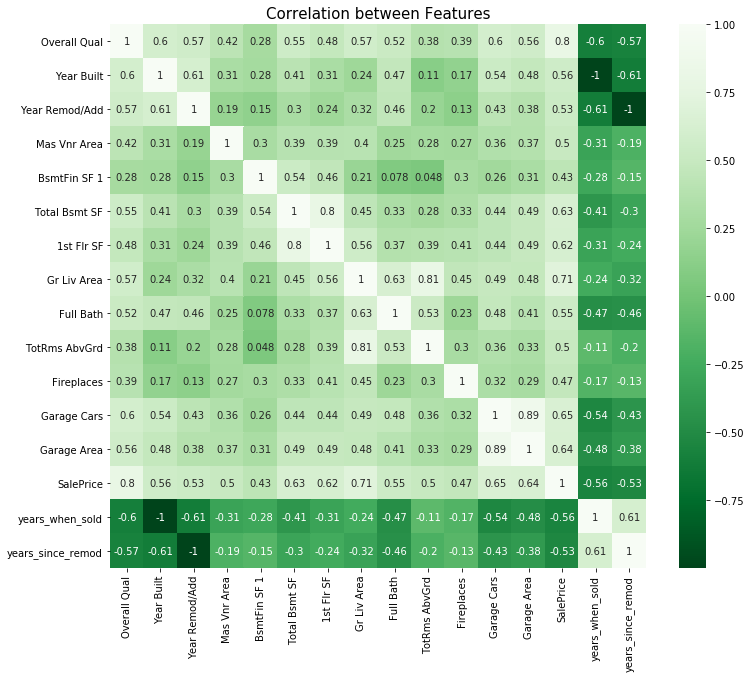

In [65]:
#Let's make a heatmap to see if there are columns that are strongly correlated

fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(transformed_df.corr(), ax=ax, annot=True, cmap='Greens_r')
plt.title('Correlation between Features', size=15)
plt.show()

 It looks like the `Garage Area` and `Garage Cars` columns are strongly correlated. Let's have a look at their [description in the documentaiton](https://s3.amazonaws.com/dq-content/307/data_description.txt):
 
- `Garage Area` - Size of garage in square feet
- `Garage Cars` - Size of garage in car capacity

Another strongly correlated pair is:

- `TotRms AbvGrd` - Total rooms above grade (does not include bathrooms)
- `Gr Liv Area` - Above grade (ground) living area square feet

Let's drop the `Garage Cars` and `TotRms AbvGrd` columns.

In [66]:
transformed_df = transformed_df.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)

Which columns in the dataframe should be converted to the categorical data type? All of the columns that can be categorized as nominal variables are candidates for being converted to categorical. Here are some other things we should think about:

- If a categorical column has hundreds of unique values (or categories), should we keep it? 
    - When we dummy code this column, hundreds of columns will need to be added back to the data frame.
- Which categorical columns have a few unique values but more than 95% of the values in the column belong to a specific category? This would be similar to a low variance numerical feature (no variability in the data for the model to capture).

In [67]:
nominal = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
          'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'House Style', 'Roof Style',
          'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 
          'Garage Type', 'Misc Feature']

- Which columns are currently numerical but need to be encoded as categorical instead?

In [68]:
cols_to_cat = []

for col in nominal:
    if col in transformed_df.columns:
        cols_to_cat.append(col)

#Let's see how many unique values each column has
unique_count = transformed_df[cols_to_cat].apply(lambda col: len(col.unique()))

#let's drop those with over 10 unique values
to_drop = unique_count[unique_count>10].index
transformed_df = transformed_df.drop(to_drop, axis=1)

In [69]:
#Let's transform 'Text' columns to 'Categorical'.

text_cols = transformed_df.select_dtypes(include=['object'])

for col in text_cols.columns:
    transformed_df[col] = transformed_df[col].astype('category')

transformed_df = pd.concat([transformed_df, 
                            pd.get_dummies(transformed_df.select_dtypes(include=['category']))]).drop(text_cols, axis=1)

Update the `select_features()` function.

In [70]:
def select_features(df):
    """Takes in a DataFrame, cleans up features which should not be used and returns the DF.
    """
    
    numeric = df.select_dtypes(include=['float', 'integer'])
    corr = numeric.corr()['SalePrice'].abs().sort_values(ascending=False)
    to_drop = corr[corr < 0.4].index
    df = df.drop(to_drop, axis=1)
    df = df.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)
    
    nominal = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
          'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'House Style', 'Roof Style',
          'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 
          'Garage Type', 'Misc Feature']
    
    cols_to_cat = []

    for col in nominal:
        if col in df.columns:
            cols_to_cat.append(col)

    unique_count = df[cols_to_cat].apply(lambda col: len(col.unique()))


    drop = unique_count[unique_count>10].index
    df = df.drop(drop, axis=1)


    text_cols = df.select_dtypes(include=['object'])

    for col in text_cols.columns:
        df[col] = df[col].astype('category')
    

    df = pd.concat([
        df, 
        pd.get_dummies(df.select_dtypes(include=['category']))
    ], axis=1).drop(text_cols,axis=1)
    
    return df
                                     
                                     

In [71]:
transformed_df = transform_features(pd.read_csv('AmesHousing.tsv', delimiter='\t'))
filtered_df = select_features(transformed_df)
rmse = train_and_test(filtered_df)

rmse

38058.28706233063

## Train And Test

Now for the final part of the pipeline, training and testing. When iterating on different features, using simple validation is a good idea. Let's add a parameter named `k` that controls the type of cross validation that occurs.

- The optional `k` parameter should accept integer values, with a default value of `0`.

- When `k` equals `0`, perform holdout validation (what we already implemented):
    - Select the first 1460 rows and assign to train.
    - Select the remaining rows and assign to test.
    - Train on train and test on test.
    - Compute the RMSE and return.
    
- When `k` equals `1`, perform simple cross validation:
    - Shuffle the ordering of the rows in the data frame.
    - Select the first 1460 rows and assign to `fold_one`.
    - Select the remaining rows and assign to `fold_two`.
    - Train on `fold_one` and test on `fold_two`.
    - Train on `fold_two` and test on `fold_one`.
    - Compute the average RMSE and return.
    
- When `k` is greater than `0`, implement k-fold cross validation using `k` folds:
    - Perform k-fold cross validation using `k` folds.
    - Calculate the average RMSE value and return this value.

In [72]:
def train_and_test(data, k=0):
    """Takes in a DataFrame and preforms KFold cross validation while using Logistic Regression mode
    Args:
        data - a DataFrame which will be used for training the model
        k (int, optional) - the number of k_splits for the cross validation
    Otputs:
        average_rmse (list) - list of the average RMSE for the different values of k
    """
    numeric_df = data.select_dtypes(include=['integer', 'float'])
    features = numeric_df.drop('SalePrice', axis=1).columns
    lr = LinearRegression()
    
    if k == 0:
        train = data[:1460]
        test = data[1460:]        
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)   
        return rmse
    
    elif k == 1:
        data = data.sample(frac=1).reset_index(drop=True)
        fold_one = data[:1460]
        fold_two = data[1460:]
        
        lr.fit(fold_one[features], fold_one['SalePrice'])
        predict_one = lr.predict(fold_two[features])
        mse_one = mean_squared_error(fold_two['SalePrice'], predict_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predict_two = lr.predict(fold_one[features])
        mse_two = mean_squared_error(fold_one['SalePrice'], predict_two)
        rmse_two = np.sqrt(mse_two)
        
        average_rmse = np.mean([rmse_one, rmse_two])
        return average_rmse
    
    else:
        kf = KFold(n_splits=k)
        rmses = []
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test['SalePrice'], predictions)
            rmses.append(np.sqrt(mse))
        average_rmse = np.mean(rmses)
        return average_rmse
        

## Final test

Finally, let's put the final versions of the three functions together and test the model.

In [73]:
def transform_features(df):
    sum_missing = df.isnull().sum()
    over_5 = sum_missing[sum_missing > len(df)/20].index
    df = df.drop(over_5, axis=1)
    
    numeric_missing = df.select_dtypes(include=['float', 'integer']).isnull().sum()
    to_fix = numeric_missing[numeric_missing > 0].sort_values()
    for col in to_fix.index:
        value = df[col].mode()[0]
        df[col] = df[col].fillna(value)
        
    object_missing = df.select_dtypes(include='object').isnull().sum()
    over_1 = object_missing[object_missing > 0].index
    df = df.drop(over_1, axis=1)
    
    df['year_until_remod'] = df['Year Remod/Add'] - df['Year Built']
    df['years_when_sold'] = df['Yr Sold'] - df['Year Built']
    df['years_since_remod'] =  df['Yr Sold'] - df['Year Remod/Add']
     
    df = df.drop(df[(df['years_when_sold'] < 0) | (df['years_since_remod'] < 0)].index)

    
    df = df.drop(['Order', 'PID', 'Mo Sold', 'Sale Type', 'Sale Condition', 'Yr Sold', 'Year Built', "Year Remod/Add"], axis=1)

    
    return df

def select_features(df, corr_coef=0.4, unique_threshold=10):
    
    numeric = df.select_dtypes(include=['float', 'integer'])
    corr = numeric.corr()['SalePrice'].abs().sort_values(ascending=False)
    to_drop = corr[corr < corr_coef].index
    df = df.drop(to_drop, axis=1)
    df = df.drop(['TotRms AbvGrd', 'Garage Cars'], axis=1)
    
    nominal = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour', 'Lot Config',
          'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'House Style', 'Roof Style',
          'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 
          'Garage Type', 'Misc Feature']
    
    cols_to_cat = []

    for col in nominal:
        if col in df.columns:
            cols_to_cat.append(col)

    unique_count = df[cols_to_cat].apply(lambda col: len(col.unique()))


    drop = unique_count[unique_count > unique_threshold].index
    df = df.drop(drop, axis=1)


    text_cols = df.select_dtypes(include=['object'])

    for col in text_cols.columns:
        df[col] = df[col].astype('category')
    

    df = pd.concat([
        df, 
        pd.get_dummies(df.select_dtypes(include=['category']))
    ], axis=1).drop(text_cols,axis=1)
    
    return df

def train_and_test(data, k=0):
    numeric_df = data.select_dtypes(include=['integer', 'float'])
    features = numeric_df.drop('SalePrice', axis=1).columns
    lr = LinearRegression()
    
    if k == 0:
        train = data[:1460]
        test = data[1460:]        
        lr.fit(train[features], train['SalePrice'])
        predictions = lr.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)   
        return rmse
    
    if k == 1:
        data = data.sample(frac=1,)
        fold_one = data[:1460]
        fold_two = data[1460:]
        
        lr.fit(fold_one[features], fold_one['SalePrice'])
        predict_one = lr.predict(fold_two[features])
        mse_one = mean_squared_error(fold_two['SalePrice'], predict_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(fold_two[features], fold_two['SalePrice'])
        predict_two = lr.predict(fold_one[features])
        mse_two = mean_squared_error(fold_one['SalePrice'], predict_two)
        rmse_two = np.sqrt(mse_two)
        
        average_rmse = np.mean([rmse_one, rmse_two])
        print("RMSE for fold 1: {}\nRMSE for fold 2: {}".format(rmse_one, rmse_two))
        return "Average RMSE for k=1: {}".format(average_rmse)
    
    else:
        kf = KFold(n_splits=k, shuffle=True)
        rmses = []
        for train_index, test_index in kf.split(data):
            train = data.iloc[train_index]
            test = data.iloc[test_index]
            lr.fit(train[features], train['SalePrice'])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test['SalePrice'], predictions)
            rmses.append(np.sqrt(mse))
        average_rmse = np.mean(rmses)
        print("RMSEs for k={}:\n{}".format(k,rmses))
        return "Average RMSE for k={}: {}".format(k, average_rmse)

In [74]:
df = transform_features(pd.read_csv('AmesHousing.tsv', delimiter='\t'))
selected = select_features(df)

In [75]:
#Test with k=0

train_and_test(selected, k=0)

33483.52751205953

In [76]:
#Test with k=1

train_and_test(selected, k=1)

RMSE for fold 1: 33237.25555596885
RMSE for fold 2: 25831.418065920665


'Average RMSE for k=1: 29534.336810944755'

In [77]:
#Test with k=4

train_and_test(selected, k=4)

RMSEs for k=4:
[26223.71232344774, 28718.426960466848, 26304.390197651835, 36467.726862899006]


'Average RMSE for k=4: 29428.564086116356'

In [78]:
#Test with k=5

train_and_test(selected, k=5)

RMSEs for k=5:
[28273.530285350404, 24367.099334733295, 24193.704430511283, 40589.23970634417, 24455.523731202225]


'Average RMSE for k=5: 28375.819497628276'

## Conclusion

In this project we used a dataset covering housing data. We cleaned up the dataset, created new useful columns and removed columns which leaked data, so that we could train a logistic regression model to predict the prices of the houses. We experimented with cross-validation with different number of splits.